In [ ]:
# pip install --quiet harmonypy

In [ ]:
# pip install --quiet git+https://github.com/theislab/scgen.git

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import harmonypy as hm

/Users/sheena/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

# Import the data

In [3]:
# adata = anndata.read_h5ad("/content/drive/MyDrive/scdata/lung_two_species_public/lung_two_species_public.h5ad")
adata = anndata.read_h5ad("../Lung_two_species_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 20760 × 62781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'celltype', 'species', 'batch', 'BATCH'
    var: 'genename-0', 'genename-1'

In [4]:
embeddings_dict = {}

In [5]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [6]:
adata.obs['cell_type'] = adata.obs['celltype'].values

### Setting: mixing and missing at the edge

#### If you want to train the Harmony again

In [ ]:
# Step 1: Run Harmony integration
sc.tl.pca(adata, n_comps=50)
data_mat = adata.obsm['X_pca']
meta_data = adata.obs

# Specify the variables to use
vars_use = ['batch']

# Run Harmony
start_time = time.time()
ho = hm.run_harmony(data_mat, meta_data, vars_use)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Convert the adjusted PCs to a DataFrame
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

# If you want to store the adjusted PCs back into the AnnData object
adata.obsm['X_harmony'] = res.values.T

In [ ]:
# Save embeddings
adata.obsm["X_harmony"] = adata.obsm["X_harmony"]

# Collect embeddings
embeddings_dict["X_harmony"] = adata.obsm["X_harmony"]

In [ ]:
# Step 2: Perform KNN on the integrated data
sc.pp.neighbors(adata, use_rep="X_harmony", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)

#### Utilize the Harmony results before in unsupervised learning

In [7]:
import pandas as pd

# Step 1: Load the saved embeddings CSV file
full_embeddings = pd.read_csv("../embeddings/full_annotated_unsupervised_lung_two_species.csv", index_col=0)

# Step 2: Ensure indices match the adata object
full_embeddings = full_embeddings.loc[adata.obs_names]

# Step 3: Extract the X_harmony embeddings
X_harmony = full_embeddings.filter(like="X_harmony")

# Step 4: Assign the embeddings back to adata.obsm
adata.obsm["X_harmony"] = X_harmony.values

# Step 5: Perform KNN and UMAP using X_harmony
sc.pp.neighbors(adata, use_rep="X_harmony", n_neighbors=30)
sc.tl.umap(adata, min_dist=0.5)

In [8]:
def reassign_edge_cells_with_unknown(adata, n_neighbors=30, threshold=0.3, random_seed=42):
    # Set the random seed for reproducibility
    np.random.seed(random_seed)
    
    # Fit nearest neighbors on the 'X_harmony' embedding
    neighbors = NearestNeighbors(n_neighbors=n_neighbors).fit(adata.obsm['X_harmony'])
    distances, indices = neighbors.kneighbors(adata.obsm['X_harmony'])

    true_labels = adata.obs['cell_type'].copy()

    # If true_labels is categorical, add "unknown" to its categories
    if pd.api.types.is_categorical_dtype(true_labels):
        true_labels = true_labels.cat.add_categories(["Unknown"])

    new_labels = true_labels.copy()

    for i in range(len(true_labels)):
        neighbor_labels = true_labels.iloc[indices[i]]
        proportion_diff = (neighbor_labels != true_labels.iloc[i]).mean()

        if proportion_diff > threshold:
            # Sample a new label based on the proportion of neighboring cell types
            label_proportions = neighbor_labels.value_counts(normalize=True)
            new_label = np.random.choice(label_proportions.index, p=label_proportions.values)

            # If the new label is the same as the original, set it to "unknown"
            if new_label == true_labels.iloc[i]:
                new_labels.iloc[i] = "Unknown"
            else:
                new_labels.iloc[i] = new_label

    adata.obs['new_labels'] = new_labels

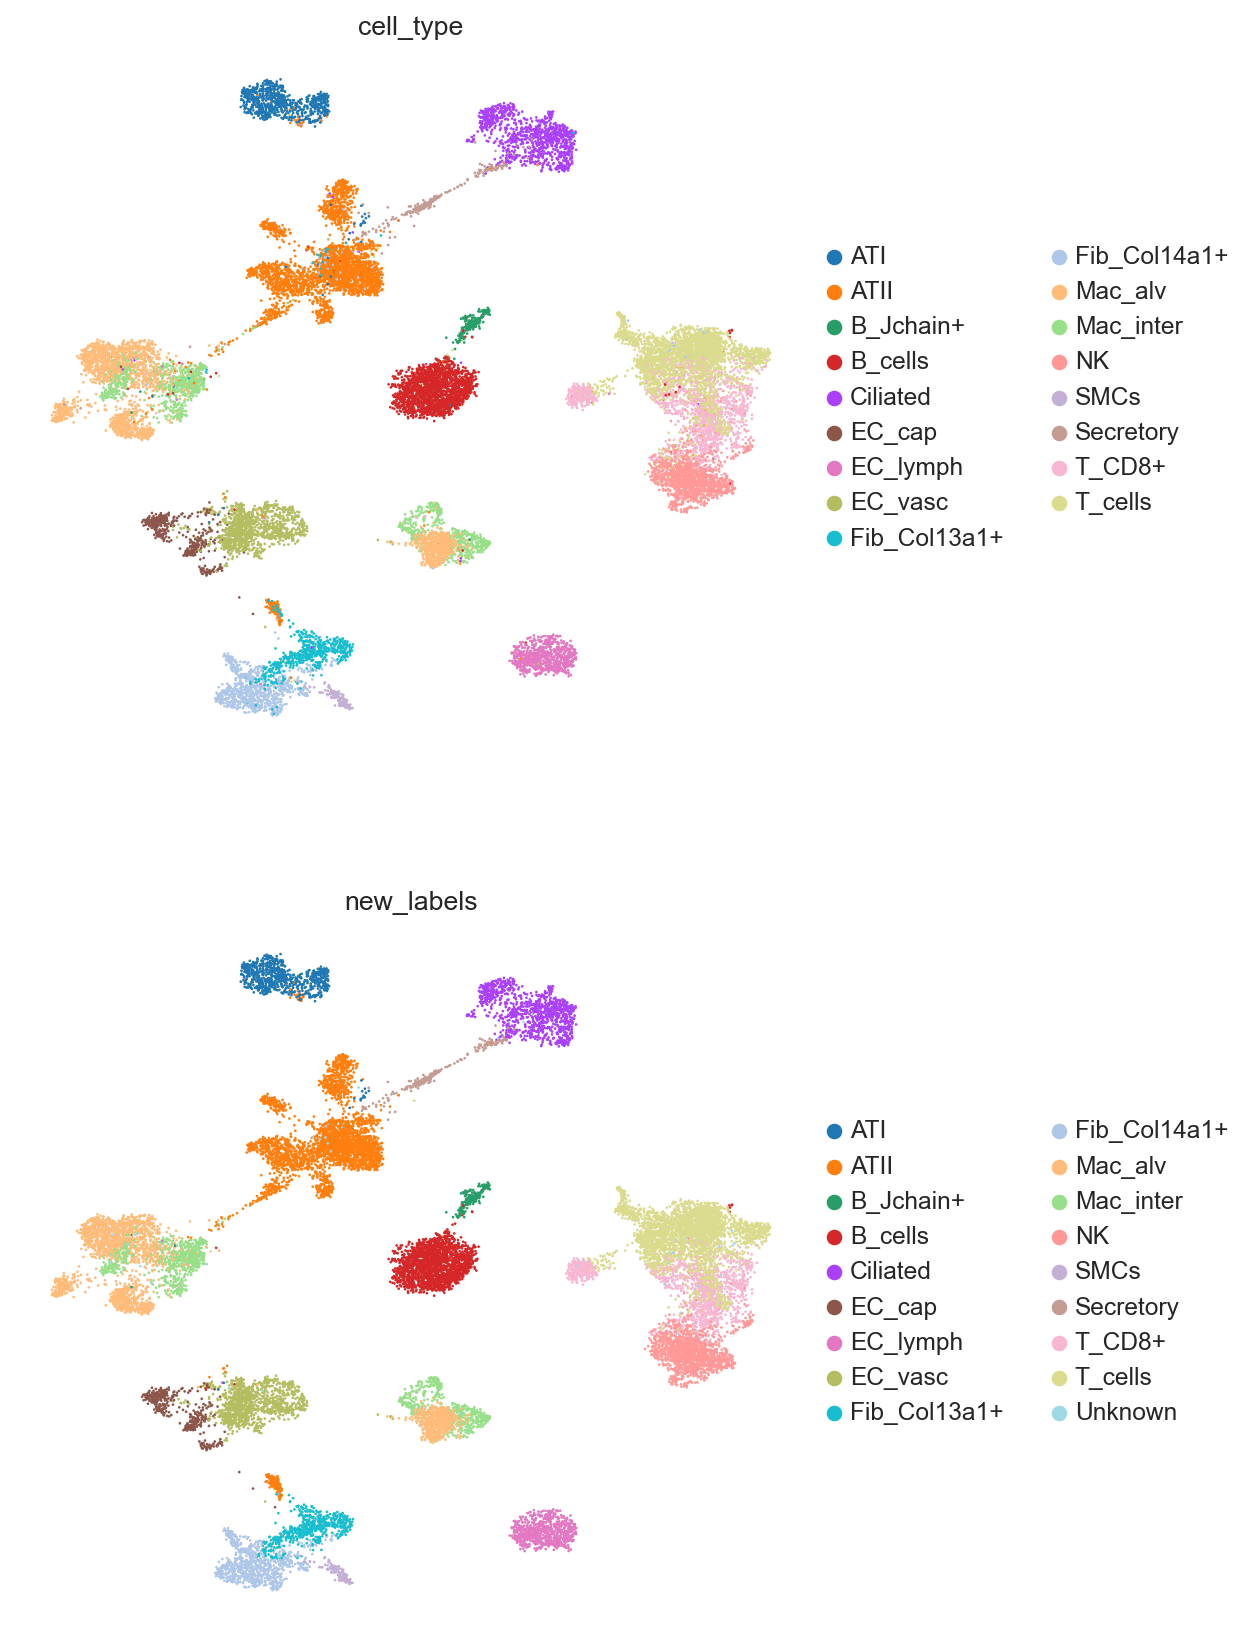

In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Apply the edge cell reassignment
reassign_edge_cells_with_unknown(adata, n_neighbors=30, threshold=0.7, random_seed=666)

# Verify results
sc.pl.umap(adata, color=['cell_type', 'new_labels'], ncols = 1)

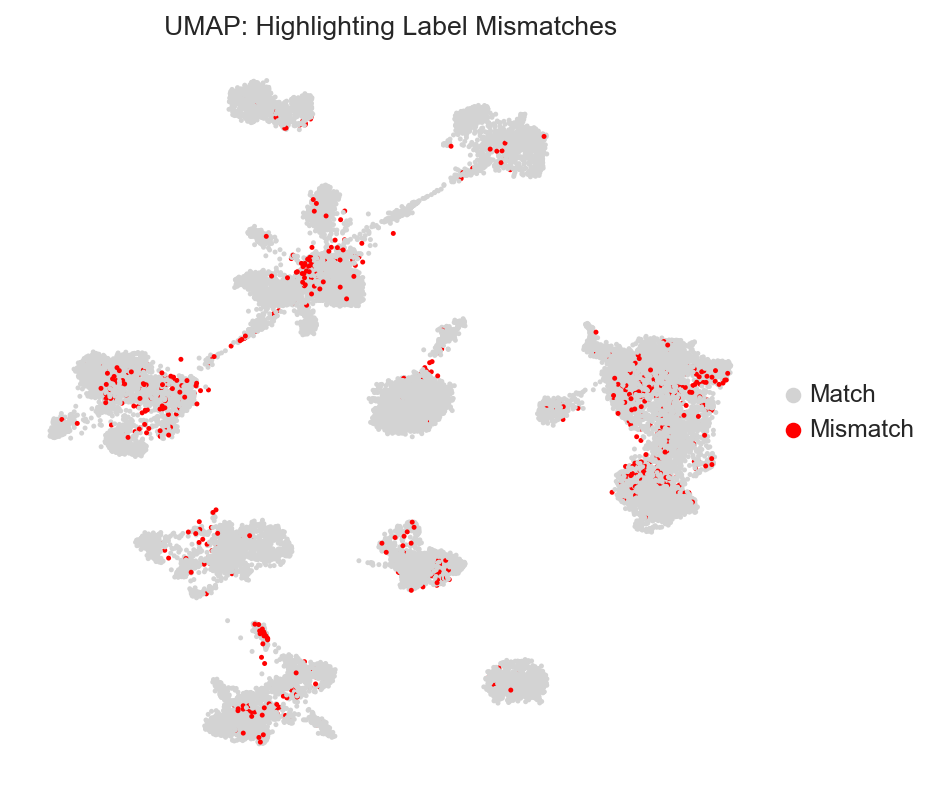

In [11]:
# Create a new column 'mismatch' indicating label differences
adata.obs['mismatch'] = np.where(
    adata.obs['new_labels'].astype(str) != adata.obs['cell_type'].astype(str),
    'Mismatch',
    'Match'
)

# Plot the UMAP with a custom palette: light gray for matching cells and red for mismatches
sc.pl.umap(
    adata, 
    color='mismatch', 
    palette=['lightgray', 'red'],
    title='UMAP: Highlighting Label Mismatches',
    size=20  # adjust point size as needed
)

In [10]:
# Convert both columns to string type and then compare
mismatch_count = (adata.obs['new_labels'].astype(str) != adata.obs['cell_type'].astype(str)).sum()

# Total number of rows
total_rows = len(adata.obs)

# Calculate the proportion of mismatches
proportion_mismatch = mismatch_count / total_rows

print("Mismatch Count:", mismatch_count)
print("Total Rows:", total_rows)
print(f"Proportion of mismatches: {proportion_mismatch:.4f}")


Mismatch Count: 970
Total Rows: 20760
Proportion of mismatches: 0.0467


In [16]:
def calculate_unknown_proportion(adata):
    unknown_count = (adata.obs['new_labels'] == "Unknown").sum()
    total_count = len(adata.obs['new_labels'])
    unknown_proportion = unknown_count / total_count
    return unknown_proportion

# Calculate the proportion of unknown cells
unknown_proportion = calculate_unknown_proportion(adata)
print(f"Proportion of unknown cells: {unknown_proportion:.2%}")

Proportion of unknown cells: 0.55%


In [17]:
adata.obs['celltype'] = adata.obs['new_labels'].values

In [18]:
adata.obs

orig.ident  nCount_RNA  nFeature_RNA sampleid  \
HC1__AAATGCCTCTGCAAGT-0             HC1      6669.0          2062     Hum1   
HC1__TTGACTTAGTGGAGAA-0             HC1      5592.0          1964     Hum1   
HC1__TTCTCAACAGCCTATA-0             HC1      8998.0          2989     Hum1   
HC1__GCAGTTATCCCTCTTT-0             HC1      6039.0          2284     Hum1   
HC1__TCTTTCCTCGGCCGAT-0             HC1     11866.0          3179     Hum1   
...                                 ...         ...           ...      ...   
fMouseTGAAAGACAATTGCTG-1  SeuratProject     11028.0          4231   fMouse   
fMouseTGGACGCAGTGCAAGC-1  SeuratProject     11221.0          4395   fMouse   
fMouseTTCCCAGTCCATGAGT-1  SeuratProject     25488.0          6796   fMouse   
fMouseTTCTCAAAGATCACGG-1  SeuratProject      2030.0          1211   fMouse   
fMouseTTGGAACGTAACGTTC-1  SeuratProject     10446.0          4135   fMouse   

                                        cellname   celltype species batch  \
HC1__AAATGCCTCTGCAAGT-0    HC1__AAATGCCTCTGCAAGT  Mac_inter   human     0   
HC1__TTGACTTAGTGGAGAA-0    HC1__TTGACTTAGTGGAGAA  Mac_inter   human     0   
HC1__TTCTCAACAGCCTATA-0    HC1__TTCTCAACAGCCTATA  Mac_inter   human     0   
HC1__GCAGTTATCCCTCTTT-0    HC1__GCAGTTATCCCTCTTT  Mac_inter   human     0   
HC1__TCTTTCCTCGGCCGAT-0    HC1__TCTTTCCTCGGCCGAT  Mac_inter   human     0   
...                                          ...        ...     ...   ...   
fMouseTGAAAGACAATTGCTG-1  fMouseTGAAAGACAATTGCTG   Ciliated   mouse     1   
fMouseTGGACGCAGTGCAAGC-1  fMouseTGGACGCAGTGCAAGC   Ciliated   mouse     1   
fMouseTTCCCAGTCCATGAGT-1  fMouseTTCCCAGTCCATGAGT   Ciliated   mouse     1   
fMouseTTCTCAAAGATCACGG-1  fMouseTTCTCAAAGATCACGG   Ciliated   mouse     1   
fMouseTTGGAACGTAACGTTC-1  fMouseTTGGAACGTAACGTTC   Ciliated   mouse     1   

                          BATCH  n_genes  n_counts  cell_type new_labels  
HC1__AAATGCCTCTGCAAGT-0   human     2062    6669.0  Mac_inter  Mac_inter  
HC1__TTGACTTAGTGGAGAA-0   human     1964    5592.0  Mac_inter  Mac_inter  
HC1__TTCTCAACAGCCTATA-0   human     2989    8998.0  Mac_inter  Mac_inter  
HC1__GCAGTTATCCCTCTTT-0   human     2284    6039.0  Mac_inter  Mac_inter  
HC1__TCTTTCCTCGGCCGAT-0   human     3179   11866.0  Mac_inter  Mac_inter  
...                         ...      ...       ...        ...        ...  
fMouseTGAAAGACAATTGCTG-1  mouse     4231   11018.0   Ciliated   Ciliated  
fMouseTGGACGCAGTGCAAGC-1  mouse     4395   11217.0   Ciliated   Ciliated  
fMouseTTCCCAGTCCATGAGT-1  mouse     6796   25469.0   Ciliated   Ciliated  
fMouseTTCTCAAAGATCACGG-1  mouse     1211    2029.0   Ciliated   Ciliated  
fMouseTTGGAACGTAACGTTC-1  mouse     4135   10434.0   Ciliated   Ciliated  

[20760 rows x 13 columns]

In [19]:
# Write `adata.obs` to a CSV file named 'metadata.csv'
adata.obs.to_csv('../R_lung_two_species/labels/missing_and_mixing_at_edge_lung_two_species_70_obs.csv', index=True)

In [ ]:
adata

### Read the labels

In [15]:
# Read the CSV with the index
new_labels_df = pd.read_csv("../R_lung_two_species/labels/missing_and_mixing_at_edge_lung_two_species_70_obs.csv", index_col=0)

# Assign the 'new_labels' column back to adata.obs
adata.obs['new_labels'] = new_labels_df['new_labels']

# scANVI

In [ ]:
# scVI
adata = adata.copy()
# adata.layers['counts'] = adata.X
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [ ]:
# Save the trained model to a specified path
model_path = "./model_scVI"
vae.save(model_path, overwrite=True)

In [25]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

In [ ]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [20]:
# Set up the AnnData object
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

# Now you can use the loaded model for further analysis or inference
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [21]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="new_labels",
    unlabeled_category="Unknown",
)

In [22]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [01:49<00:00,  5.55s/it, v_num=1, train_loss_step=426, train_loss_epoch=436]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:49<00:00,  5.46s/it, v_num=1, train_loss_step=426, train_loss_epoch=436]


In [23]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [24]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [25]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

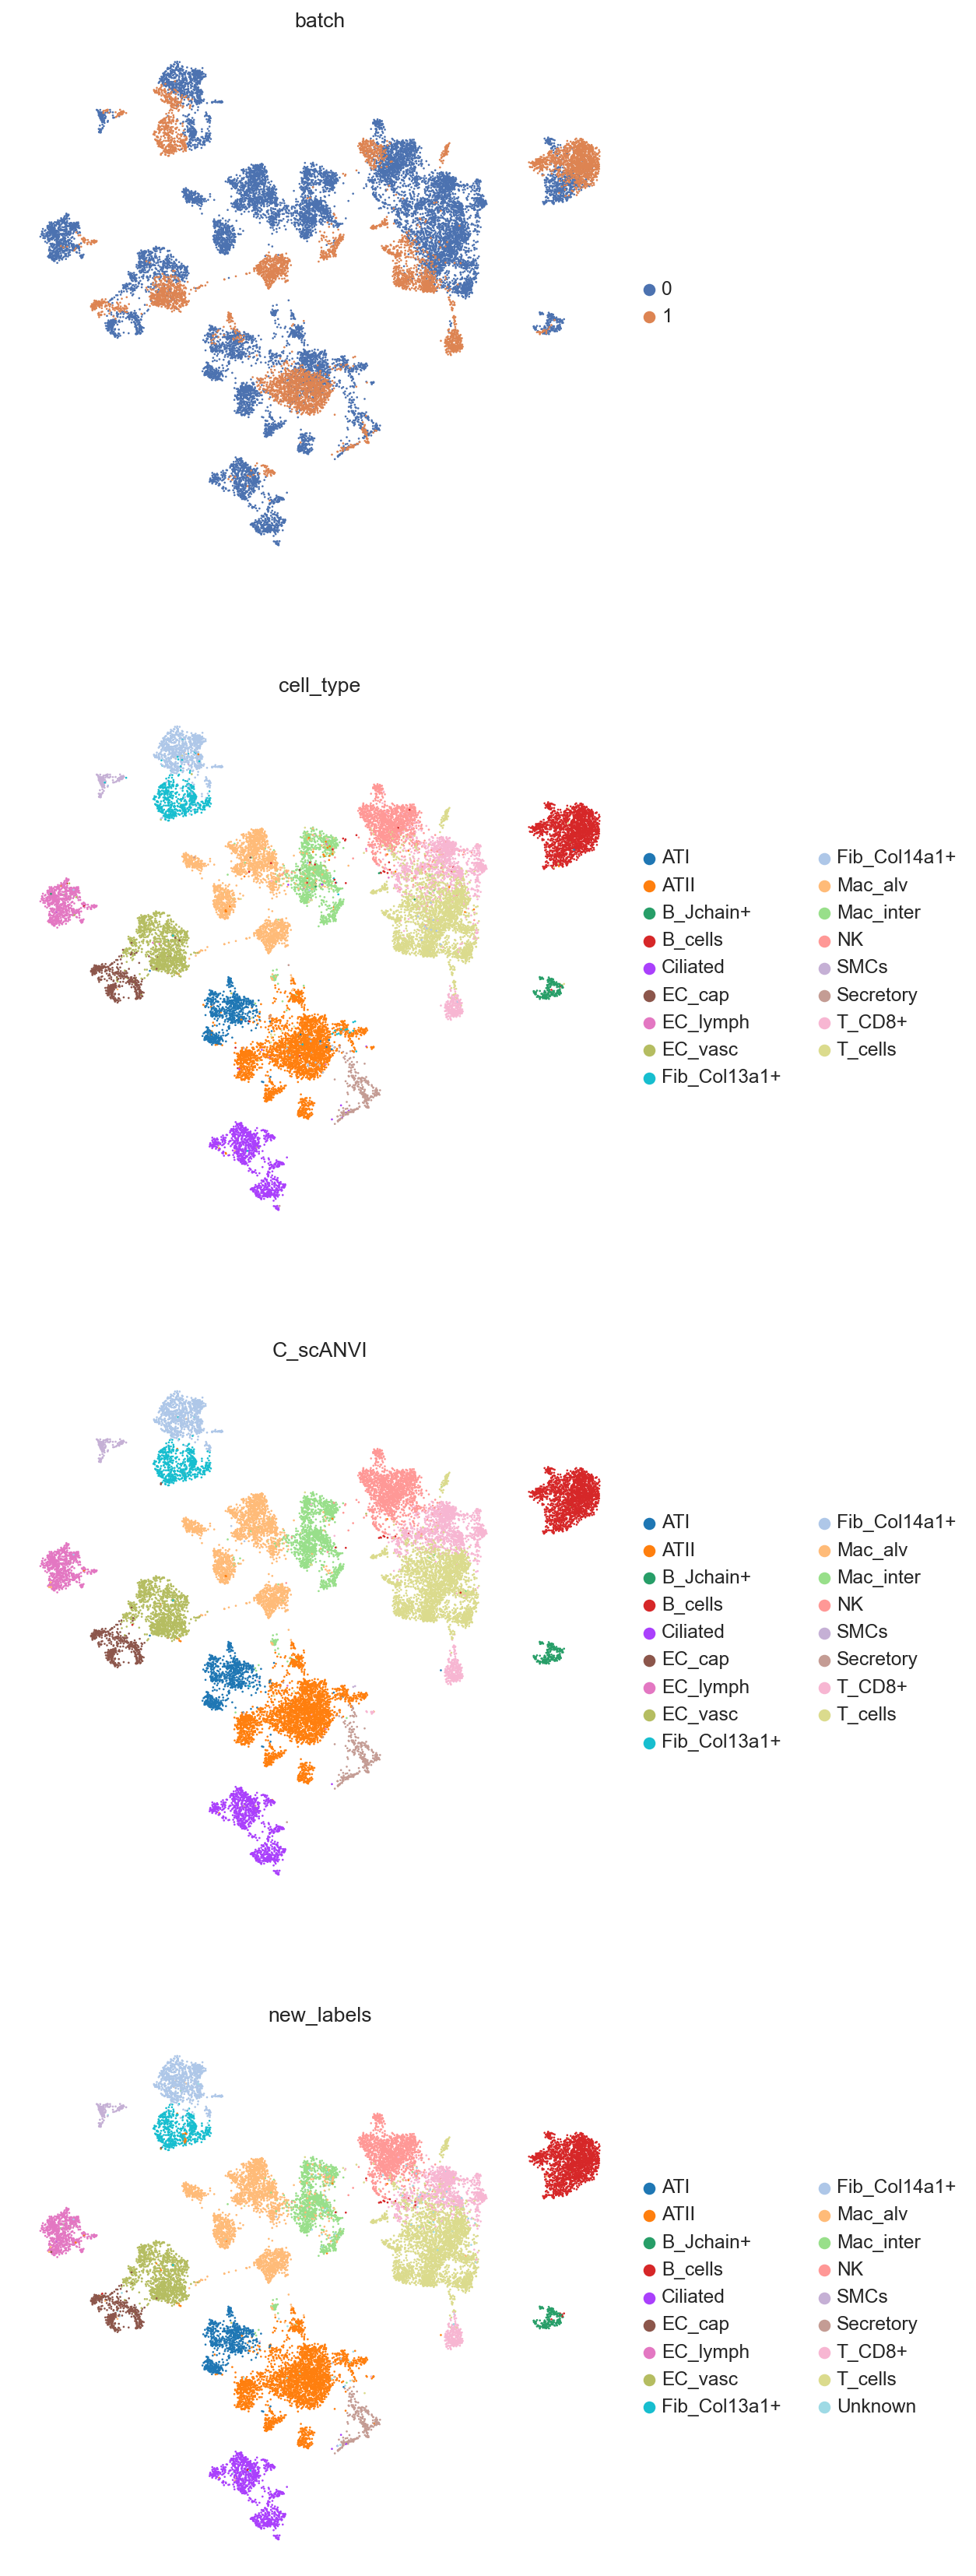

In [26]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI", "new_labels"], frameon=False, ncols=1)

# scGEN

In [27]:
train = adata.copy()

### Preprocessing Data

In [28]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="new_labels")

## Creating and Training the model¶

In [29]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|██▌       | 26/100 [04:36<13:07, 10.64s/it, v_num=1, train_loss_step=88.4, train_loss_epoch=81.7]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 739.330. Signaling Trainer to stop.


## Batch-Removal

In [30]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 20760 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'celltype', 'species', 'batch', 'BATCH', 'n_genes', 'n_counts', 'cell_type', 'new_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [31]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [32]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

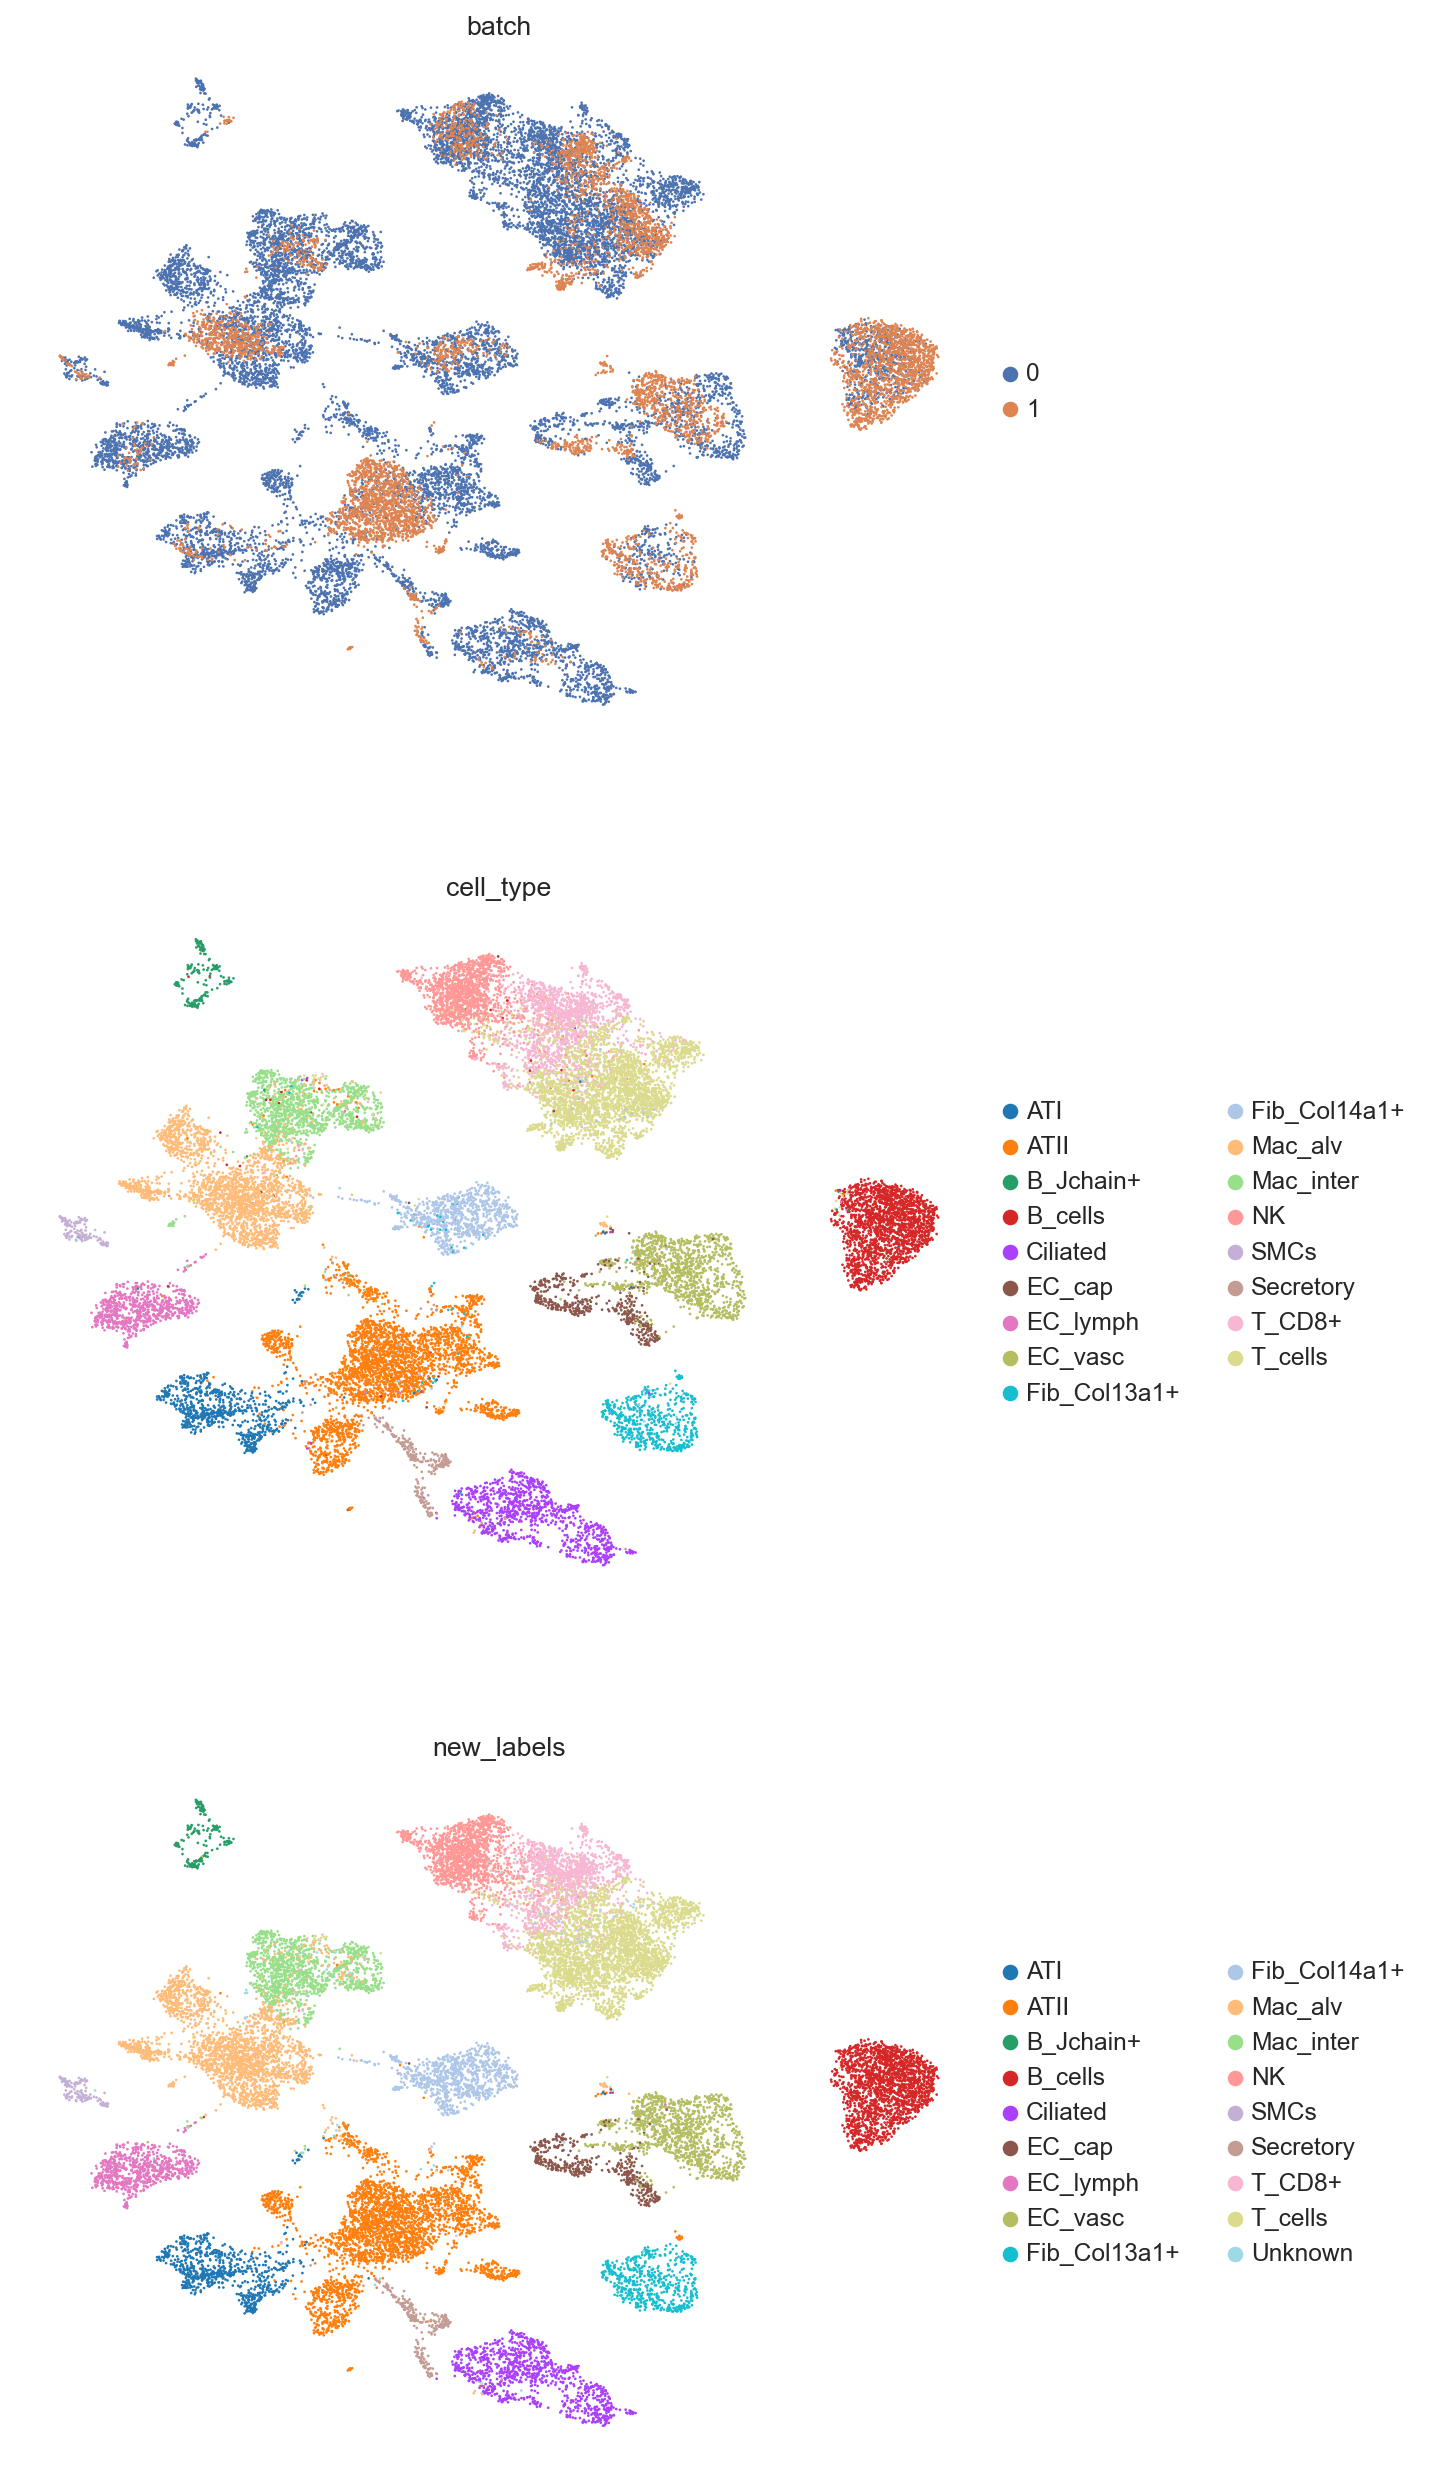

In [33]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type', 'new_labels'], wspace=0.4, frameon=False, ncols=1)

# STACAS

Semi-supervised integration results

In [34]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/lung_two_species_stacas_embeddings_missing_and_mixing_at_edge_70.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [35]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

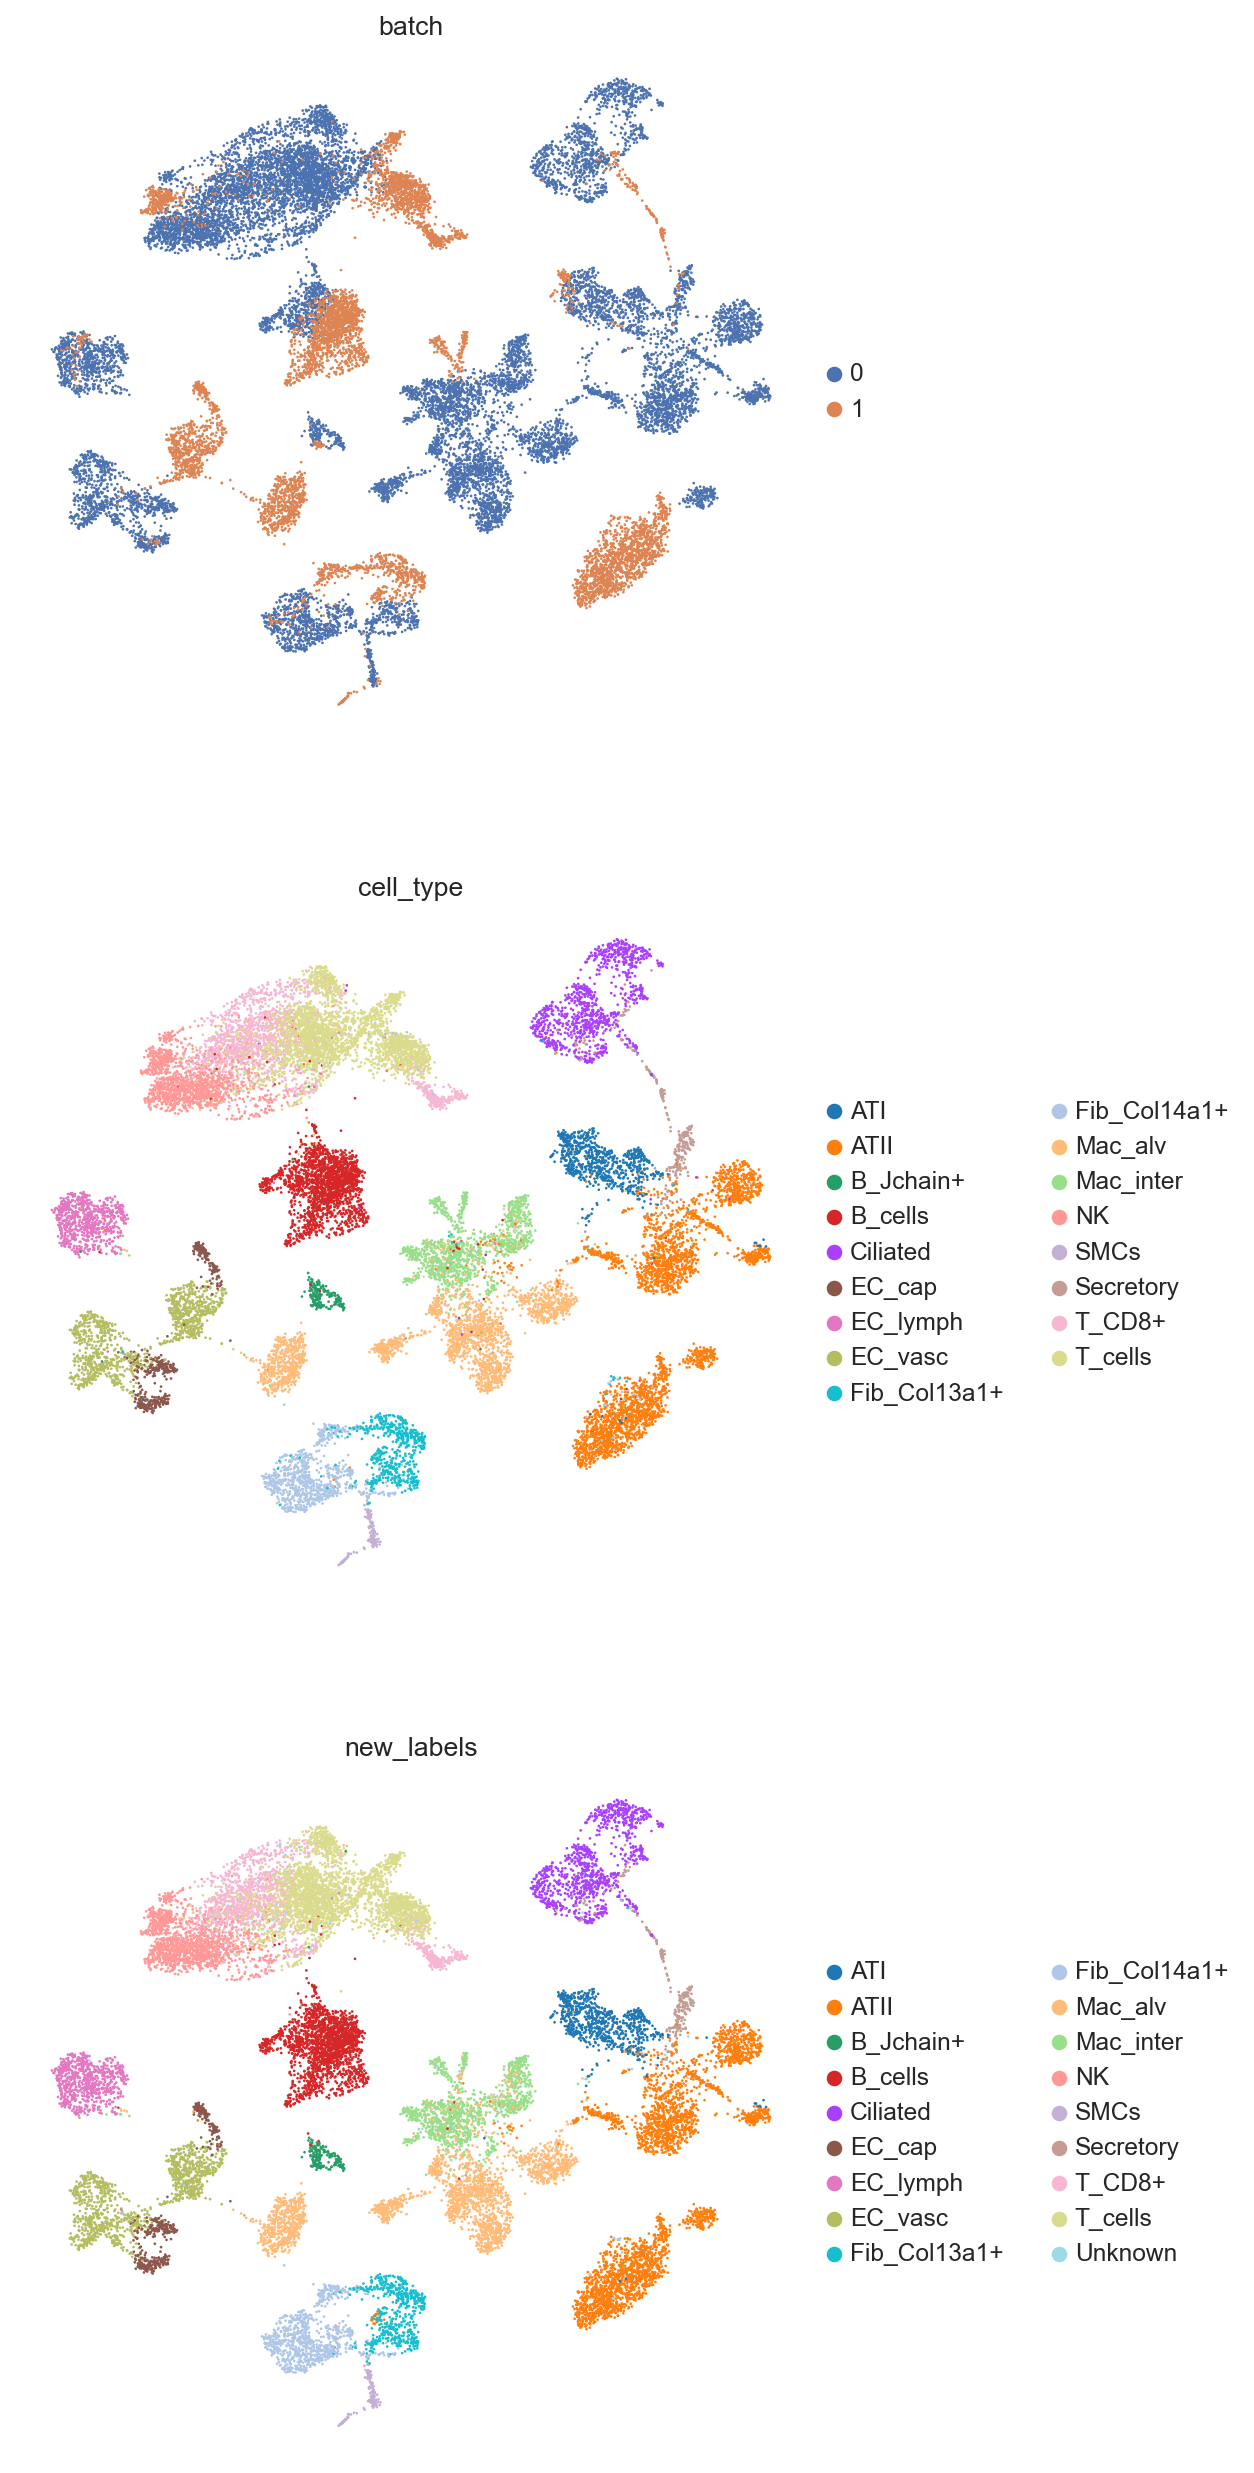

In [36]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

# scDREAMER

In [37]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/mixing_and_missing_at_edge_lung_two_species_70_scdreamer_embeddings.csv', index_col=0)
adata.obsm['X_scDREAMER'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_scDREAMER")
sc.tl.umap(adata, min_dist=0.5)

In [38]:
# Collect embeddings
embeddings_dict["X_scDREAMER"] = pca_embeddings.values

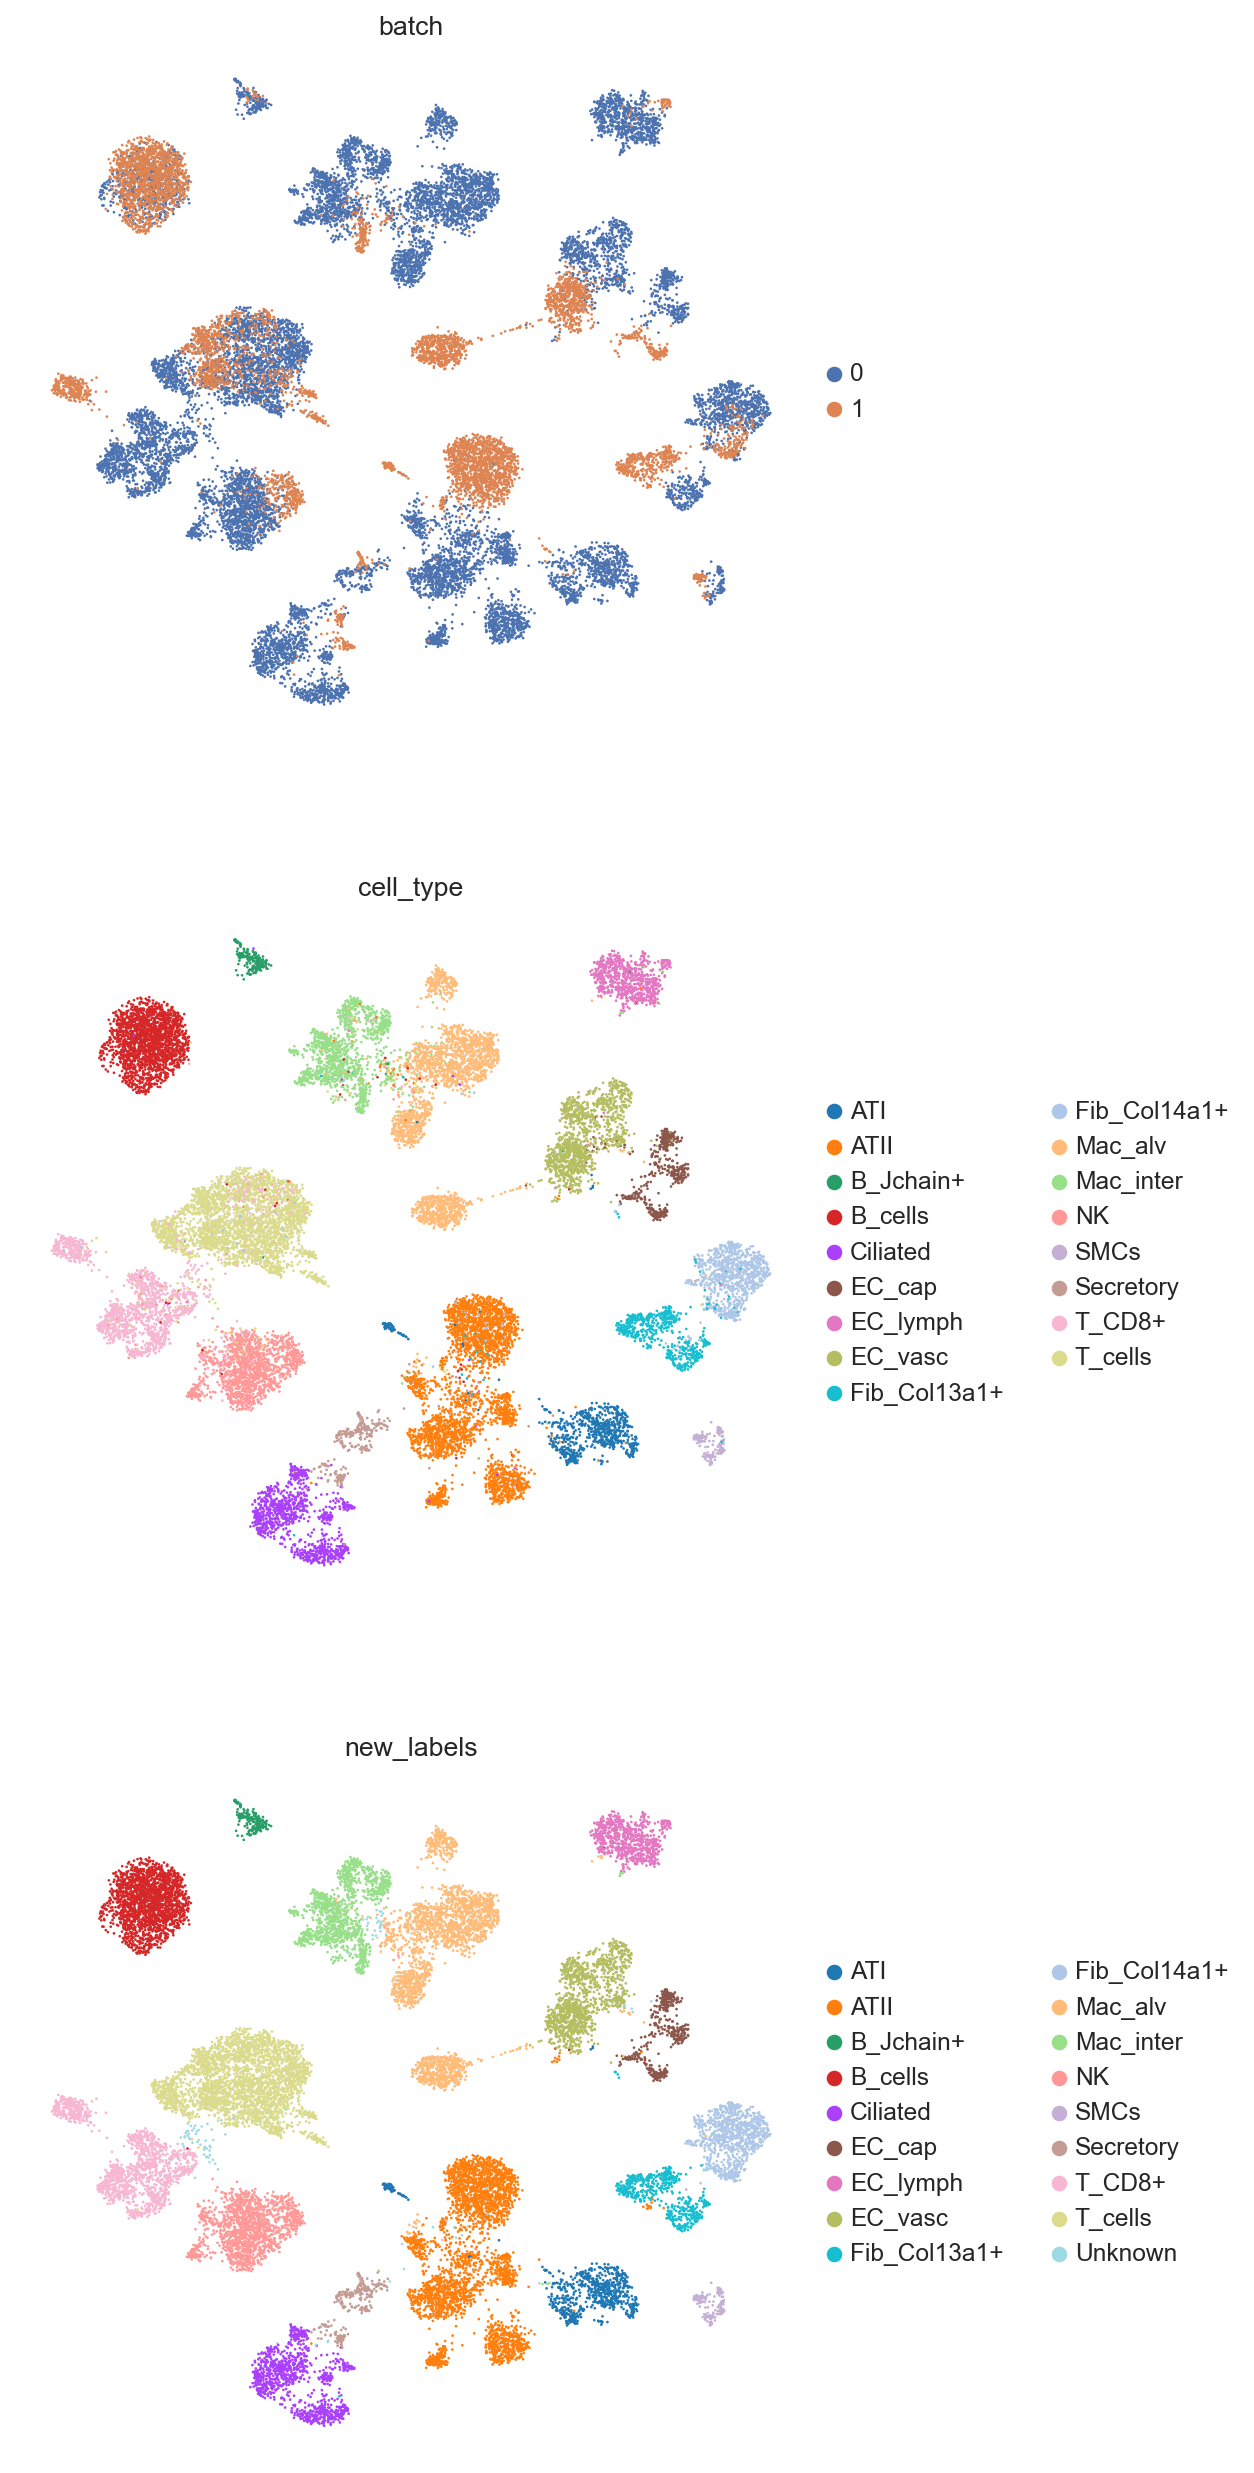

In [39]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

# ItClust

In [40]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/mixing_and_missing_at_edge_lung_two_species_70_itclust_embeddings.csv', index_col=0)
adata.obsm['X_itclust'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_itclust")
sc.tl.umap(adata, min_dist=0.5)

In [41]:
# Collect embeddings
embeddings_dict["X_itclust"] = pca_embeddings.values

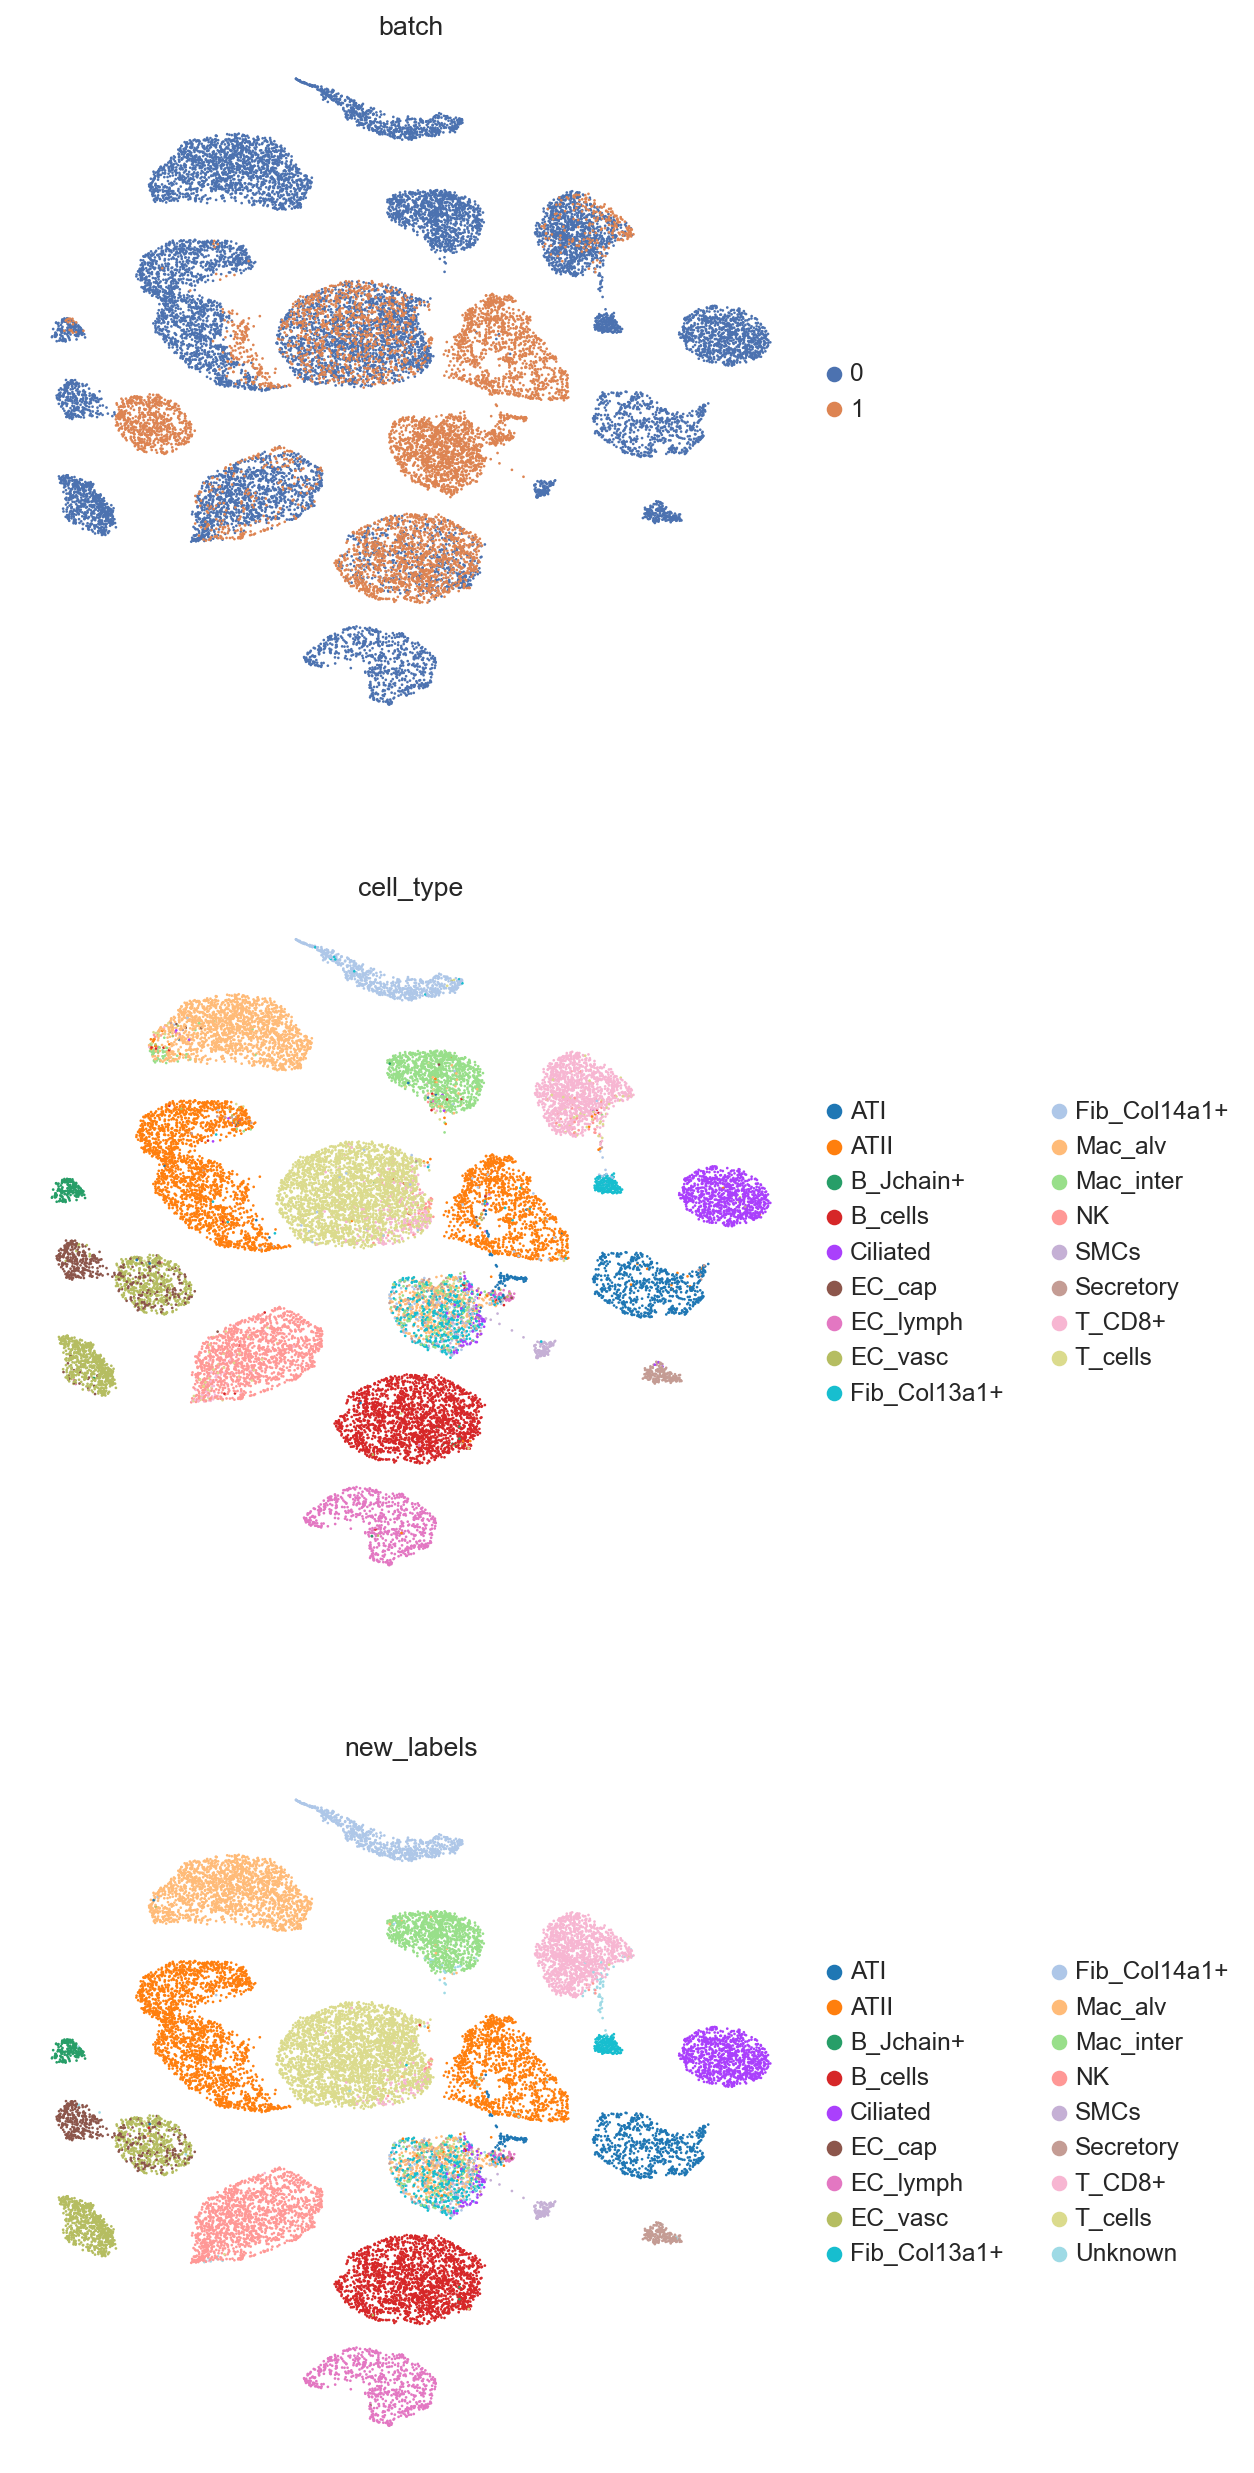

In [42]:
sc.pl.umap(adata, color=["batch", "cell_type", "new_labels"], frameon=False, ncols=1)

In [43]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/missing_and_mixing_at_edge_lung_two_species_70.csv")


# Metric Evaluation

## read the embeddings

In [8]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/missing_and_mixing_at_edge_lung_two_species_70.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas", "X_scDREAMER", "X_itclust"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

## Bio-conservation

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, ilisi_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, clisi_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

In [ ]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df_cell = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df_cell